## Imports required for this project

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [29]:
# Set seed for reproducibility
tf.random.set_seed(4)

### Define paths using pathlib.Path

In [64]:
train_path = Path("../input/fer2013/train")
test_path = Path("../input/fer2013/test")

In [65]:
# Function to get label from image path
def get_label(image_path):
    return image_path.parent.name

In [66]:
# Get image paths and corresponding labels
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x: str(x), train_image_paths))
train_image_labels = list(map(lambda x: get_label(Path(x)), train_image_paths))

In [67]:
# Get image paths and corresponding labels
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(Path(x)), test_image_paths))

In [33]:
# Label encoding
label_encoder = LabelEncoder()
train_image_labels_encoded = label_encoder.fit_transform(train_image_labels)
train_image_labels_encoded = tf.keras.utils.to_categorical(train_image_labels_encoded)

In [34]:
# Split data into training and validation sets
Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels_encoded, test_size=0.25)

In [35]:
# Calculate class weights
class_totals = Train_labels.sum(axis=0)
class_weight = class_totals.max() / class_totals
class_weight = {idx: weight for idx, weight in enumerate(class_weight)}

In [36]:
# Define image size and batch size
IMG_SIZE = 96
BATCH_SIZE = 32

In [37]:
# Function to load and preprocess images
def load_image(image, label):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

In [38]:
# Create TensorFlow Dataset objects
def create_dataset(paths, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(paths))
    dataset = dataset.batch(BATCH_SIZE)
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [39]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
])

In [40]:
# Create training and validation datasets
train_dataset = create_dataset(Train_paths, Train_labels, augment=True)
val_dataset = create_dataset(Val_paths, Val_labels)

In [41]:
# Display sample images from the datasets
def show_sample(dataset):
    for images, labels in dataset.take(1):
        for i in range(3):  # Display 3 samples
            plt.imshow(images[i])
            plt.title(label_encoder.inverse_transform(np.argmax(labels[i])))
            plt.axis("off")
            plt.show()

In [42]:
def show_sample(dataset):
    for images, labels in dataset.take(1):
        for i in range(3):  # Display 3 samples
            plt.imshow(images[i])
            # Check if labels are one-hot encoded and convert them to integer labels
            if labels[i].shape == ():
                label = int(labels[i])
            else:
                label = np.argmax(labels[i])
            plt.title(label_encoder.inverse_transform([label])[0])  # Pass a 1D array to inverse_transform
            plt.axis("off")
            plt.show()

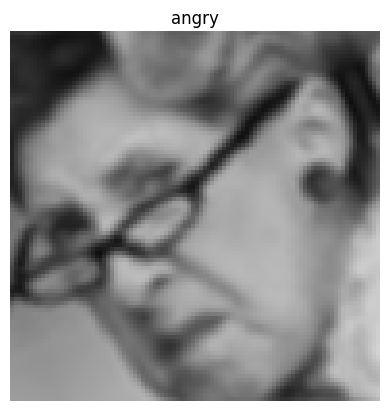

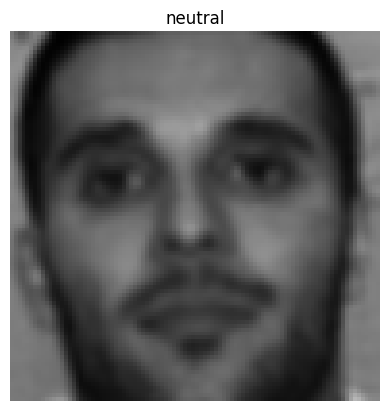

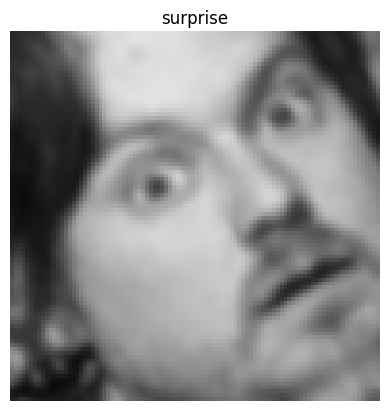

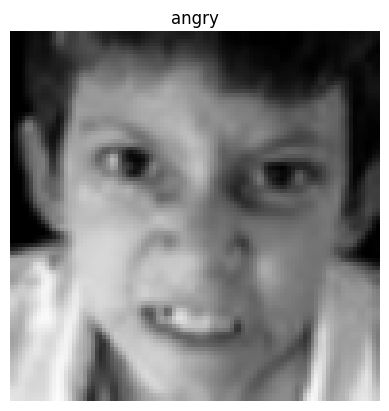

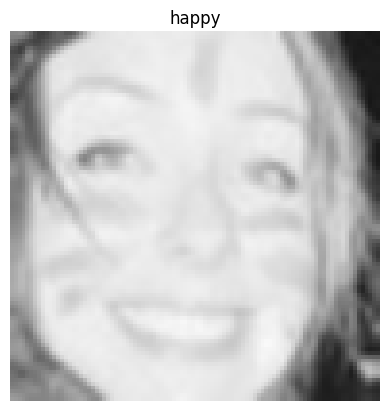

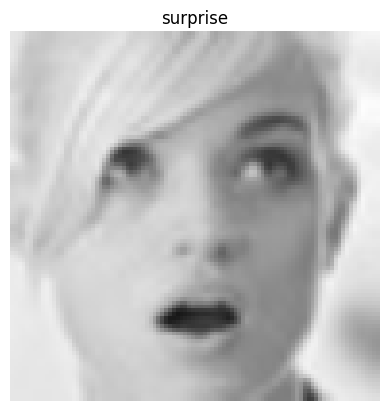

In [43]:
show_sample(train_dataset)
show_sample(val_dataset)

## Building `EfficientNet` model

In [44]:
from tensorflow.keras.applications import EfficientNetB7

In [45]:
backbone = EfficientNetB7(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'  # Use pre-trained weights
)

In [46]:
# Add classification head to the backbone
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

In [47]:
## Model Summmary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [48]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [49]:
# Train the model with early stopping and checkpointing
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths) // BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps=len(Val_paths) // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("../working/best_weights.weights.h5", verbose=1, save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.EarlyStopping(patience=4)
    ]
)

Epoch 1/12


I0000 00:00:1711214698.493447      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/672 ━━━━━━━━━━━━━━━━━━━━ 71:14:49 382s/step - accuracy: 0.0938 - loss: 3.2728 - precision: 0.0000e+00 - recall: 0.0000e+00

W0000 00:00:1711214698.865548      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3237 - loss: 3.1867 - precision: 0.6031 - recall: 0.1198

W0000 00:00:1711214877.016443      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.68732, saving model to ../working/best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 576s 289ms/step - accuracy: 0.3237 - loss: 3.1863 - precision: 0.6033 - recall: 0.1198 - val_accuracy: 0.3938 - val_loss: 1.6873 - val_precision: 0.7085 - val_recall: 0.1597
Epoch 2/12
  1/672 ━━━━━━━━━━━━━━━━━━━━ 47:40:20 256s/step - accuracy: 0.4074 - loss: 2.8908 - precision: 0.8571 - recall: 0.2222

W0000 00:00:1711215148.287326      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4317 - loss: 2.6649 - precision: 0.6917 - recall: 0.2077

W0000 00:00:1711215318.462638      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 2: val_loss improved from 1.68732 to 1.39027, saving model to ../working/best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 442s 277ms/step - accuracy: 0.4317 - loss: 2.6648 - precision: 0.6917 - recall: 0.2077 - val_accuracy: 0.4656 - val_loss: 1.3903 - val_precision: 0.5989 - val_recall: 0.3317
Epoch 3/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4894 - loss: 2.3933 - precision: 0.6884 - recall: 0.2795
Epoch 3: val_loss improved from 1.39027 to 1.31563, saving model to ../working/best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 173s 258ms/step - accuracy: 0.4894 - loss: 2.3933 - precision: 0.6884 - recall: 0.2795 - val_accuracy: 0.4941 - val_loss: 1.3156 - val_precision: 0.6810 - val_recall: 0.3298
Epoch 4/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5140 - loss: 2.2693 - precision: 0.7016 - recall: 0.3060
Epoch 4: val_loss improved from 1.31563 to 1.19775, saving model to ../working/best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 173s 

In [52]:
# Load the best weights
model.load_weights("../working/best_weights.weights.h5")

In [89]:
# Label encoding
label_encoder = LabelEncoder()
test_image_labels_encoded = label_encoder.fit_transform(test_labels)
test_image_labels_encoded = tf.keras.utils.to_categorical(test_image_labels_encoded)

In [90]:
test_dataset = create_dataset(test_image_paths, test_image_labels_encoded)

In [ ]:
# Evaluate the model on the test set

loss, accuracy, precision, recall = model.evaluate(test_dataset)

 102713/Unknown 6218s 60ms/step - accuracy: 0.5960 - loss: 1.1018 - precision: 0.6973 - recall: 0.4848

In [ ]:
print("Testing Loss:", loss)
print("Testing Accuracy:", accuracy)
print("Testing Precision:", precision)
print("Testing Recall:", recall)

In [ ]:
# Save the model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder for later use
import joblib

In [ ]:
joblib.dump(label_encoder, "LabelEncoder.pkl")